In [2]:
import requests
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import contextily as ctx

In [39]:
pd.set_option('display.max_rows', 500)


In [4]:
forecast_weather_df = pd.read_csv("../data/train/forecast_weather.csv")

In [7]:
unique_coords_forecast = np.unique(forecast_weather_df[["latitude", "longitude"]], axis=0)

In [8]:
points = [Point(x, y) for y, x in unique_coords_forecast]
points_gdf = gpd.GeoDataFrame(points, columns=['geometry'])

## Get Estonia's boundaries¶


In [9]:
def order_ways(list_list_points):
    #list_first_points = [list_points[0] for list_points in list_list_points]
    #list_last_points = [list_points[-1] for list_points in list_list_points]
    ordered_list_list_points = []
    first_list_point = list_list_points[0]
    list_points = list_list_points[0]
    last_point = 0
    while (last_point != first_list_point[-1]):
        ordered_list_list_points.append(list_points)
        list_list_points.remove(list_points)
        list_first_points = [list_points[0] for list_points in list_list_points]
        list_last_points = [list_points[-1] for list_points in list_list_points]
        #print(list_points[0])
        #print(list_points[-1])
        #print()
        last_point = list_points[-1]
        try:
            index_list_points = list_first_points.index(last_point)
            list_points = list_list_points[index_list_points]
        except ValueError:
            try:
                index_list_points = list_last_points.index(last_point)
                list_points = list_list_points[index_list_points]
                list_points.reverse()
            except ValueError:
                break
        last_point = list_points[-1]
    return ordered_list_list_points

In [6]:
# create query
overpass_query_counties = """
[out:json];
area["name:en"="Estonia"]->.searchArea;
(
  relation["admin_level"="6"](area.searchArea);
);
out geom;
"""


# get Estonia boundaries from overpass
response = requests.post("https://overpass-api.de/api/interpreter", data=overpass_query_counties)
estonia_geojson = response.json()

# parse geometry
geometry = []
names = []
for element in estonia_geojson['elements']:
    members = element['members']
    name = element["tags"]["alt_name"]
    names.append(name)
    coords_poly = []
    for member in members:
        if member['type'] == 'way' and 'geometry' in member:
            coords = [(node['lon'], node['lat']) for node in member['geometry']]
            coords_poly.append(coords)
            #geometry.append(LineString(coords))
    coords_poly = order_ways(coords_poly)
    coords_poly = list(chain(*coords_poly))
    geometry.append(Polygon(coords_poly))

name_series = pd.Series(names, name="County")
gdf = gpd.GeoDataFrame(name_series, geometry=geometry)
gdf = gdf.set_index("County")
gdf.crs = 'EPSG:4326'

In [28]:
gdf

,geometry
County,
Saaremaa,"POLYGON ((21.64083 58.74281, 21.60667 58.68833..."
Pärnumaa,"POLYGON ((24.06525 58.76243, 24.06507 58.76238..."
Hiiumaa,"POLYGON ((22.73333 59.29167, 22.60333 59.29500..."
Läänemaa,"POLYGON ((24.09365 58.98936, 24.10263 58.99037..."
Ida-Virumaa,"POLYGON ((26.79538 59.40712, 26.80395 59.40645..."
Harjumaa,"POLYGON ((24.16252 59.02535, 24.16657 59.02435..."
Lääne-Virumaa,"POLYGON ((26.79538 59.40712, 26.80395 59.40645..."
Tartumaa,"POLYGON ((26.67412 58.63174, 26.67416 58.63169..."
Valgamaa,"POLYGON ((26.05763 58.09585, 26.05499 58.09556..."


In [32]:
# create query
overpass_query_land_area = """
[out:json];
area["name:en"="Estonia"]->.searchArea;
(
  relation[boundary=land_area][admin_level=2](area.searchArea);
);
out geom;
"""

# get Estonia boundaries from overpass
response = requests.post("https://overpass-api.de/api/interpreter", data=overpass_query_land_area)
land_area_geojson = response.json()

# parse geometry
geometry = []
members = land_area_geojson['elements'][0]['members']
coords_poly = []
for member in members:
    if member['type'] == 'way' and 'geometry' in member:
        coords = [(node['lon'], node['lat']) for node in member['geometry']]
        coords_poly.append(coords)
        #geometry.append(LineString(coords))
coords_poly = order_ways(coords_poly)
coords_poly = list(chain(*coords_poly))
geometry.append(Polygon(coords_poly))

gdf_land = gpd.GeoDataFrame(geometry=geometry)
gdf_land.crs = 'EPSG:4326'

In [35]:
# create query
overpass_query_hiiumaa = """
[out:json];
area["name:en"="Estonia"]->.searchArea;
(
  relation[place=island][name="Hiiumaa"](area.searchArea);
);
out geom;
"""

# get Estonia boundaries from overpass
response = requests.post("https://overpass-api.de/api/interpreter", data=overpass_query_hiiumaa)
hiiumaa_geojson = response.json()

# parse geometry
geometry = []
members = hiiumaa_geojson['elements'][0]['members']
coords_poly = []
for member in members:
    if member['type'] == 'way' and 'geometry' in member:
        coords = [(node['lon'], node['lat']) for node in member['geometry']]
        coords_poly.append(coords)
        #geometry.append(LineString(coords))
coords_poly = order_ways(coords_poly)
coords_poly = list(chain(*coords_poly))
geometry.append(Polygon(coords_poly))

gdf_hiiumaa = gpd.GeoDataFrame(geometry=geometry)
gdf_hiiumaa.crs = 'EPSG:4326'

In [36]:
# create query
overpass_query_saaremaa = """
[out:json];
area["name:en"="Estonia"]->.searchArea;
(
  relation[place=island][name="Saaremaa"](area.searchArea);
);
out geom;
"""

# get Estonia boundaries from overpass
response = requests.post("https://overpass-api.de/api/interpreter", data=overpass_query_saaremaa)
saaremaa_geojson = response.json()

# parse geometry
geometry = []
members = saaremaa_geojson['elements'][0]['members']
coords_poly = []
for member in members:
    if member['type'] == 'way' and 'geometry' in member:
        coords = [(node['lon'], node['lat']) for node in member['geometry']]
        coords_poly.append(coords)
        #geometry.append(LineString(coords))
coords_poly = order_ways(coords_poly)
coords_poly = list(chain(*coords_poly))
geometry.append(Polygon(coords_poly))

gdf_saaremaa = gpd.GeoDataFrame(geometry=geometry)
gdf_saaremaa.crs = 'EPSG:4326'

<Axes: >

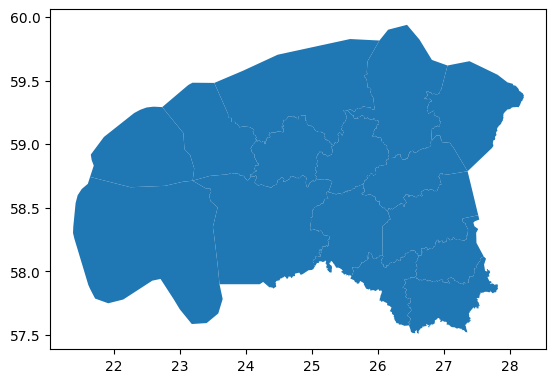

In [30]:

gdf.plot( linewidth=3)

<Axes: >

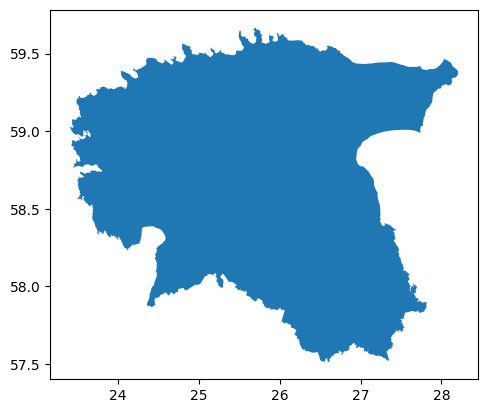

In [34]:
gdf_land.plot()

In [41]:
display(gdf_land)
display(gdf_hiiumaa)
gdf_saaremaa.values

,geometry
0,"POLYGON ((23.66113 58.97234, 23.66103 58.97236..."


,geometry
0,"POLYGON ((22.50372 58.69849, 22.50380 58.69846..."


array([[<POLYGON ((22.04 58.005, 22.039 58.005, 22.039 58.004, 22.039 58.004, 22.039...>]],
      dtype=object)

In [50]:
clipped_gdf = gpd.clip(gdf, gdf_land)


<Axes: >

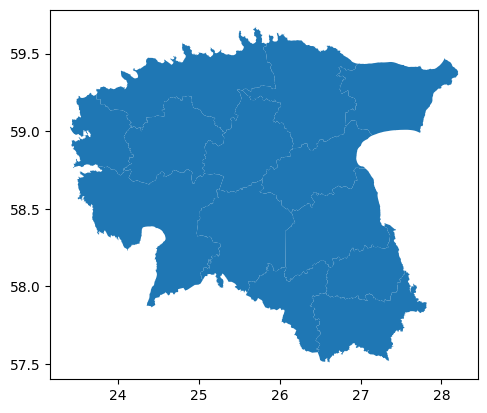

In [51]:
clipped_gdf.plot()

<Axes: >

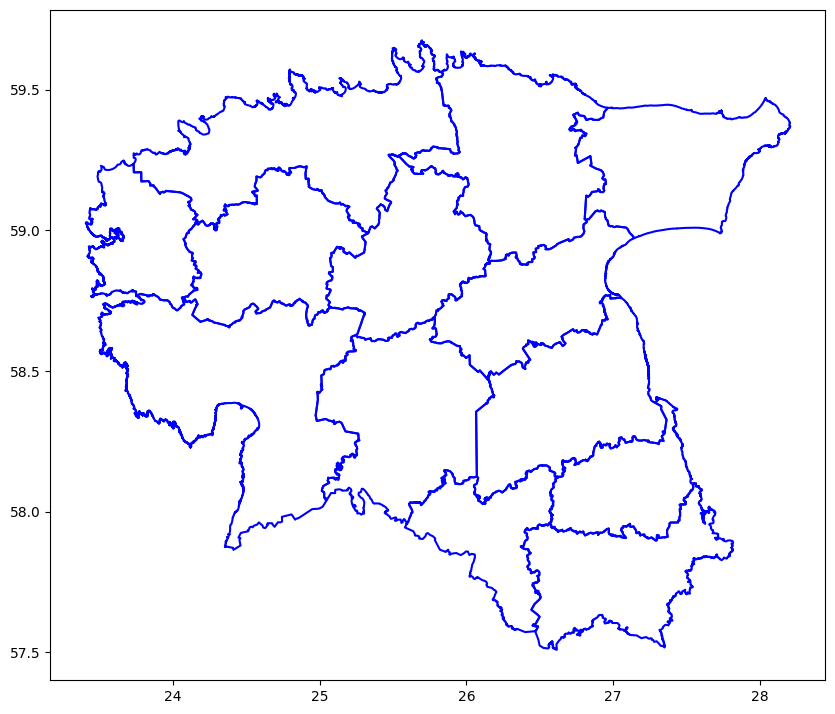

In [54]:
boundaries = clipped_gdf.boundary

fig, ax = plt.subplots(figsize=(10, 10))
boundaries.plot(ax=ax, color='blue')  


In [62]:
merged_gdf = pd.concat([clipped_gdf, gdf_hiiumaa, gdf_saaremaa])


<Axes: >

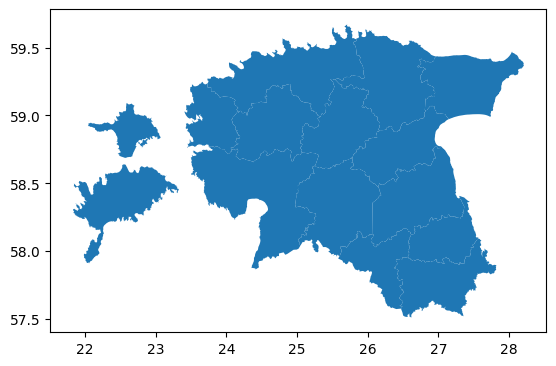

In [56]:
merged_gdf.plot()

In [64]:
merged_gdf.columns

Index(['geometry'], dtype='object')

In [65]:
merged_gdf.at[gdf.index[-2]] = 'Hiiumaa'
merged_gdf.at[gdf.index[-1]] = 'Saaremaa'

ValueError: Invalid call for scalar access (setting)!

In [68]:
merged_gdf

,geometry
Pärnumaa,"POLYGON ((23.75353 58.76885, 23.75479 58.76913..."
Viljandimaa,"POLYGON ((26.13315 58.38399, 26.13111 58.38292..."
Järvamaa,"POLYGON ((25.06455 58.72965, 25.06415 58.72977..."
Raplamaa,"POLYGON ((25.05509 58.75245, 25.06037 58.74994..."
Läänemaa,"POLYGON ((23.73076 59.23530, 23.73082 59.23435..."
Harjumaa,"POLYGON ((24.16657 59.02435, 24.16762 59.02553..."
Võrumaa,"POLYGON ((27.64377 58.00102, 27.64463 58.00029..."
Valgamaa,"POLYGON ((26.05499 58.09556, 26.05478 58.09543..."
Põlvamaa,"POLYGON ((27.55426 58.10075, 27.55383 58.10054..."
Tartumaa,"POLYGON ((27.28868 58.38716, 27.30303 58.38297..."


In [79]:
df1 = pd.DataFrame(merged_gdf)


In [80]:
df1

,geometry
Pärnumaa,"POLYGON ((23.75353 58.76885, 23.75479 58.76913..."
Viljandimaa,"POLYGON ((26.13315 58.38399, 26.13111 58.38292..."
Järvamaa,"POLYGON ((25.06455 58.72965, 25.06415 58.72977..."
Raplamaa,"POLYGON ((25.05509 58.75245, 25.06037 58.74994..."
Läänemaa,"POLYGON ((23.73076 59.23530, 23.73082 59.23435..."
Harjumaa,"POLYGON ((24.16657 59.02435, 24.16762 59.02553..."
Võrumaa,"POLYGON ((27.64377 58.00102, 27.64463 58.00029..."
Valgamaa,"POLYGON ((26.05499 58.09556, 26.05478 58.09543..."
Põlvamaa,"POLYGON ((27.55426 58.10075, 27.55383 58.10054..."
Tartumaa,"POLYGON ((27.28868 58.38716, 27.30303 58.38297..."
